In [1]:
%matplotlib inline

In [2]:
from utils import *

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)
Using Theano backend.


We would like to finetune all of the FC layers of the VGG model, so:

1. Create a new model of only the FC layers, but without any dropout
1. Calculate the output of the conv layers of our VGG model and save the results as features for the FC layers.
1. Fit the data to the new FC model
1. Load the weights from the FC model to the full network

### Get the VGG

In [18]:
# Get a VGG model that's finetuned for 2 classes instead of Imagenet's 1000
vgg_model = vgg_ft(2)

In [19]:
DATA_DIR = '../data/dogscatsredux/'
WEIGHTS_DIR = DATA_DIR + 'saved-weights/'
OLD_WEIGHTS = WEIGHTS_DIR + 'fit3.h5f'
ARRAYS_DIR = DATA_DIR + 'arrays/'

In [20]:
vgg_model.load_weights(OLD_WEIGHTS)

In [21]:
# Get the index of the last MaxPooling2D layer in the VGG model.
# All the layers to this index will not be trained and will be used to calculate the training/validation sets values before the FC layers.
# All the layers from this index (including) will be fine tuned.
layer_idx = len(vgg_model.layers) - next(idx for idx,layer in enumerate(reversed(vgg_model.layers)) if type(layer) == MaxPooling2D)

In [22]:
vgg_model.layers[layer_idx:]

In [23]:
vgg_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_4 (Lambda)                (None, 3, 224, 224)   0           lambda_input_4[0][0]             
____________________________________________________________________________________________________
zeropadding2d_40 (ZeroPadding2D) (None, 3, 226, 226)   0           lambda_4[0][0]                   
____________________________________________________________________________________________________
convolution2d_40 (Convolution2D) (None, 64, 224, 224)  0           zeropadding2d_40[0][0]           
____________________________________________________________________________________________________
zeropadding2d_41 (ZeroPadding2D) (None, 64, 226, 226)  0           convolution2d_40[0][0]           
___________________________________________________________________________________________

In [24]:
# Get the training/validation batches
batch_size = 64
trn_batches = get_batches(DATA_DIR + 'train/', batch_size=batch_size, class_mode='categorical', shuffle=False)
val_batches = get_batches(DATA_DIR + 'valid/', batch_size=batch_size, class_mode='categorical', shuffle=False)

Found 22778 images belonging to 2 classes.
Found 2222 images belonging to 2 classes.


In [25]:
trn_classes = trn_batches.classes
val_classes = val_batches.classes

trn_labels = onehot(trn_classes)
val_labels = onehot(val_classes)

In [26]:
trn_labels

array([[ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       ..., 
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.]])

In [27]:
# Get all of the FC layers
fc_layers = vgg_model.layers[layer_idx:]
fc_layers

In [28]:
# Get all of the conv layers
conv_layers = vgg_model.layers[:layer_idx]
conv_layers

In [29]:
# Create a new model only from the conv layers
conv_model = Sequential(conv_layers)

In [151]:
# Get the output of train/validate from the conv model. This will be used as input for the FC model
trn_features = conv_model.predict_generator(trn_batches, trn_batches.nb_sample)
val_features = conv_model.predict_generator(val_batches, val_batches.nb_sample)

KeyboardInterrupt: 

In [31]:
trn_features.shape, val_features.shape

((22778, 512, 7, 7), (2222, 512, 7, 7))

In [100]:
save_array(ARRAYS_DIR + 'lesson3-trn-ft.data', trn_features)
save_array(ARRAYS_DIR + 'lesson3-val-ft.data', val_features)

save_array(ARRAYS_DIR + 'lesson3-trn-lbls.data', trn_labels)
save_array(ARRAYS_DIR + 'lesson3-val-lbls.data', val_labels)

In [30]:
trn_features = load_array(ARRAYS_DIR + 'lesson3-trn-ft.data')
val_features = load_array(ARRAYS_DIR + 'lesson3-val-ft.data')

trn_labels = load_array(ARRAYS_DIR + 'lesson3-trn-lbls.data')
val_labels = load_array(ARRAYS_DIR + 'lesson3-val-lbls.data')

In [32]:
trn_features[:5]

array([[[[   0.    ,    0.    ,    0.    , ...,    0.    ,    0.    ,    0.    ],
         [   0.    ,    0.    ,    0.    , ...,    0.    ,    0.    ,    0.    ],
         [   0.    ,    0.    ,    0.    , ...,    0.    ,    0.    ,    0.    ],
         ..., 
         [   2.0766,    0.    ,    0.    , ...,    0.    ,    0.    ,    0.    ],
         [   0.    ,    0.    ,    0.    , ...,    0.    ,    0.    ,    0.    ],
         [   0.    ,    0.    ,    0.    , ...,    0.    ,    0.    ,    0.    ]],

        [[   0.    ,    0.    ,    0.    , ...,    0.    ,    0.    ,    0.    ],
         [   0.    ,    0.    ,    0.    , ...,    0.    ,    0.    ,    0.    ],
         [   0.    ,    0.    ,    0.    , ...,    0.    ,    1.03  ,    0.    ],
         ..., 
         [   0.    ,    0.    ,    0.    , ...,    0.    ,    0.    ,    0.    ],
         [   0.    ,    0.    ,    0.    , ...,    0.    ,    0.    ,    0.    ],
         [   0.    ,    0.    ,    0.    , ...,    0.    ,    0.  

In [33]:
conv_layers[-1].output_shape[1:]

(512, 7, 7)

In [34]:
# Create a FC model that's similar in structure to VGG's FC layers, but remove the dropout.

def get_fc_model():
    fc_model = Sequential()
    fc_model.add(Flatten(input_shape=conv_layers[-1].output_shape[1:]))
    fc_model.add(Dense(4096, activation='relu'))
    fc_model.add(Dropout(0))
    fc_model.add(Dense(4096, activation='relu'))
    fc_model.add(Dropout(0))
    fc_model.add(Dense(2, activation='softmax'))
    
    # Load the weights to the FC model
    for idx, layer in enumerate(fc_model.layers):
        layer.set_weights(fc_layers[idx].get_weights())
    
    return fc_model

In [20]:
fc_model = get_fc_model()

opt = RMSprop(lr=0.00001, rho=0.7)
fc_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [21]:
fc_model.fit(trn_features, trn_labels, batch_size=batch_size, nb_epoch=8, validation_data=(val_features, val_labels))

Train on 22778 samples, validate on 2222 samples
Epoch 1/8
22778/22778 [==============================] - 31s - loss: 0.0442 - acc: 0.9894 - val_loss: 0.0916 - val_acc: 0.9847
Epoch 2/8
22778/22778 [==============================] - 31s - loss: 0.0075 - acc: 0.9989 - val_loss: 0.1103 - val_acc: 0.9824
Epoch 3/8
22778/22778 [==============================] - 31s - loss: 0.0033 - acc: 0.9996 - val_loss: 0.1235 - val_acc: 0.9842
Epoch 4/8
22778/22778 [==============================] - 31s - loss: 0.0032 - acc: 0.9998 - val_loss: 0.1177 - val_acc: 0.9824
Epoch 5/8
22778/22778 [==============================] - 31s - loss: 0.0030 - acc: 0.9998 - val_loss: 0.1175 - val_acc: 0.9838
Epoch 6/8
22778/22778 [==============================] - 31s - loss: 0.0027 - acc: 0.9998 - val_loss: 0.1198 - val_acc: 0.9833
Epoch 7/8
22778/22778 [==============================] - 31s - loss: 0.0026 - acc: 0.9998 - val_loss: 0.1164 - val_acc: 0.9856
Epoch 8/8
22778/22778 [==============================] - 31s -

In [22]:
vgg_model.save_weights(WEIGHTS_DIR + 'l3-fit-1.h5f')

In [23]:
vgg_model.load_weights(WEIGHTS_DIR + 'l3-fit-1.h5f')

In [24]:
test_batches = get_batches(DATA_DIR + 'test/', batch_size=batch_size, class_mode='categorical', shuffle=False)

Found 12500 images belonging to 1 classes.


In [120]:
preds = vgg_model.predict_generator(test_batches, test_batches.nb_sample, )

In [198]:
# predictions = []
# for idx, filename in enumerate(test_batches.filenames):
#     img_id = filename[len('unknown/'):-len('.jpg')]
#     predictions.append([ img_id, max(min(preds[idx][1], 0.96), 0.04) ])

In [25]:
def prepare_predictions(preds, min_pred=0.04, max_pred=0.96):
    
    # Create the np.array for the data.
    dogs_preds = np.array(preds)[:, 1]
    dogs_preds = np.array([test_batches.filenames, dogs_preds])
    dogs_preds = dogs_preds.T
    
    # Create a DF and convert the file name to image ID
    dogs_preds = pd.DataFrame(dogs_preds)
    dogs_preds[0] = dogs_preds[0].apply(lambda x: x[len('unknown/'):-len('.jpg')])
    
    # Convert the label and prediction to numeric values (from strings)
    dogs_preds[1] = pd.to_numeric(dogs_preds[1])
    dogs_preds[0] = pd.to_numeric(dogs_preds[0])
    
    # Clip the predictions to min_pred, max_pred
    dogs_preds[1] = dogs_preds[1].clip(min_pred, max_pred)
    
    # Add labels to the columns
    dogs_preds.columns = ['id', 'label']
    
    # Sort the rows according to the ID
    dogs_preds = dogs_preds.sort_values('id')
    
    return dogs_preds

In [209]:
dogs_preds = prepare_predictions(preds)

In [210]:
dogs_preds

,id,label
7082,1,0.96
4067,2,0.96
3558,3,0.96
5730,4,0.96
2852,5,0.04
3896,6,0.04
9565,7,0.04
8351,8,0.04
9270,9,0.04
6412,10,0.04


In [26]:
def write_csv(df, fname):
    df.to_csv(fname, index=False)

In [214]:
write_csv(dogs_preds1, 'submissions-fc-fit2.csv')

## Data Augmentation

### Try out Data Augmentation

In [36]:
# Create a sample with one image in order to more easily play around with the images
SINGLE_FILE_DIR = DATA_DIR + 'single-image/'
%mkdir -p '$SINGLE_FILE_DIR'cats/
%cp '$DATA_DIR'train/cats/cat.1.jpg '$SINGLE_FILE_DIR'cats/

In [37]:
# Use a Data Augmentation generator to augment the image
aug_gen = image.ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.5,
    zoom_range=0.15,
#     horizontal_flip=True,
)

# Create a one image batch
aug_sample_batch = get_batches(SINGLE_FILE_DIR, gen=aug_gen, batch_size=8, shuffle=False)

Found 1 images belonging to 1 classes.


In [89]:
imgs = []
for i in range(8):
    img, lbl = next(aug_sample_batch)
    imgs.append(img)
imgs = np.array(imgs)

[None, None, None, None, None, None, None, None]

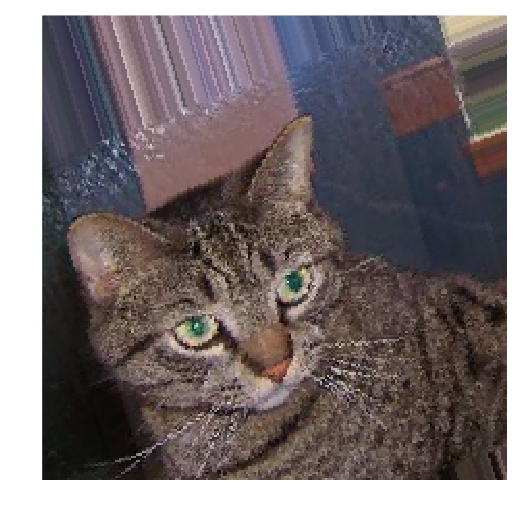

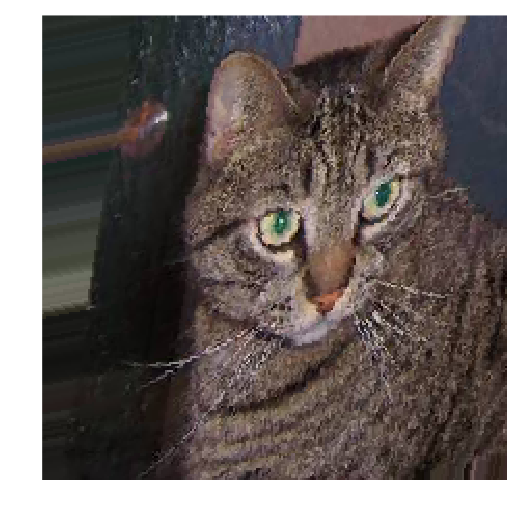

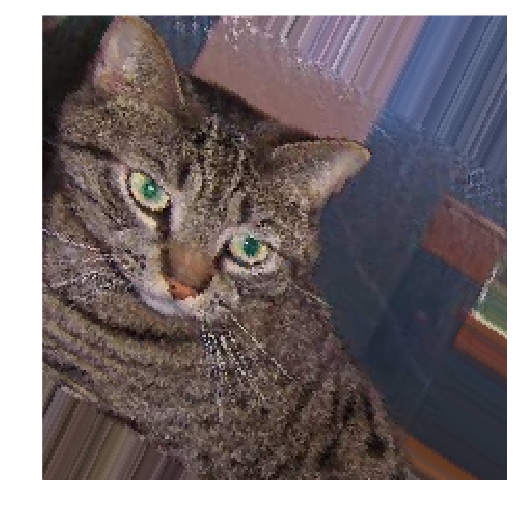

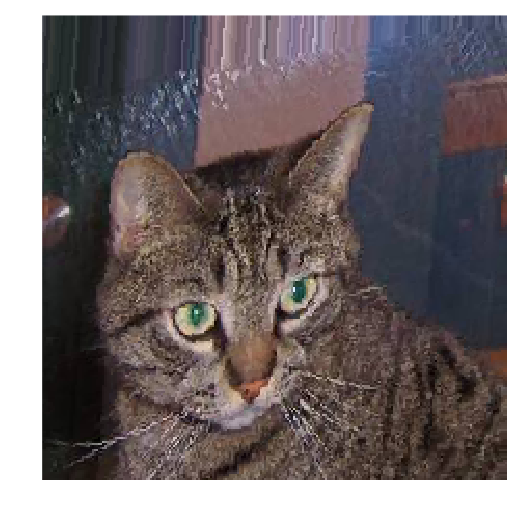

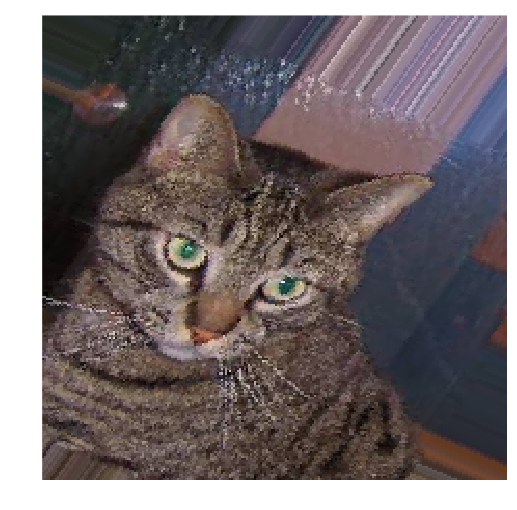

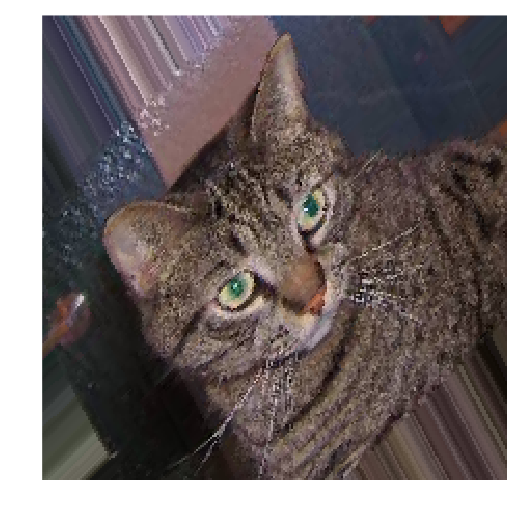

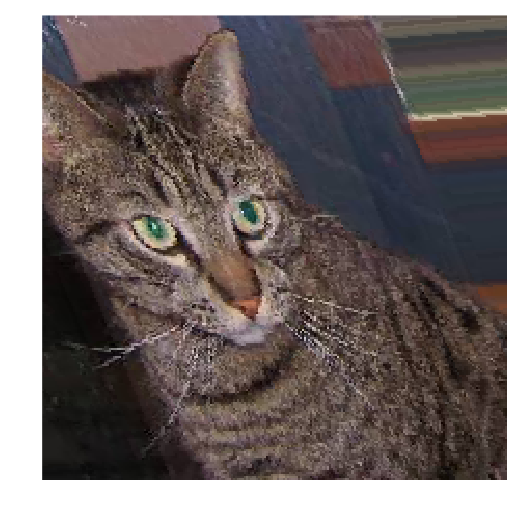

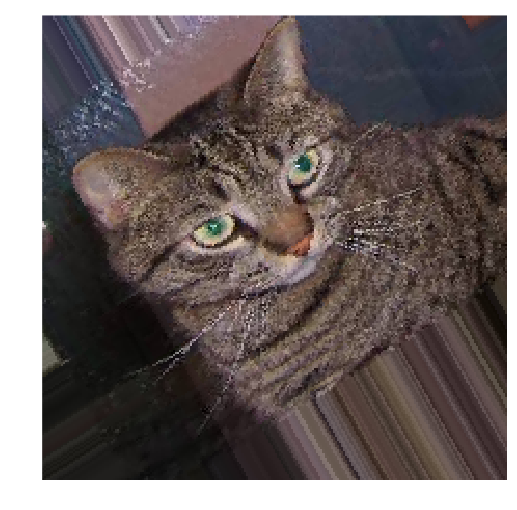

In [90]:
# Plot the results of 8 augmented images
[plots(img) for img in imgs]
# len(imgs)

### Use Data Augmentation in the model

In [38]:
vgg_model = vgg_ft(2)
vgg_model.load_weights(WEIGHTS_DIR + 'l3-fit-1.h5f')
layer_idx = len(vgg_model.layers) - next(idx for idx,layer in enumerate(reversed(vgg_model.layers)) if type(layer) == MaxPooling2D)
conv_layers = vgg_model.layers[:layer_idx]
fc_model = get_fc_model()

In [39]:
conv_model = Sequential(conv_layers)
for layer in conv_model.layers:
    layer.trainable = False
conv_model.add(fc_model)

In [40]:
# Recompile
opt = RMSprop(lr=0.00001, rho=0.7)
conv_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [41]:
conv_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_5 (Lambda)                (None, 3, 224, 224)   0           lambda_input_5[0][0]             
____________________________________________________________________________________________________
zeropadding2d_53 (ZeroPadding2D) (None, 3, 226, 226)   0           lambda_5[0][0]                   
____________________________________________________________________________________________________
convolution2d_53 (Convolution2D) (None, 64, 224, 224)  0           zeropadding2d_53[1][0]           
____________________________________________________________________________________________________
zeropadding2d_54 (ZeroPadding2D) (None, 64, 226, 226)  0           convolution2d_53[1][0]           
___________________________________________________________________________________________

In [42]:
# Get the training/validation batches
batch_size = 64
trn_batches = get_batches(DATA_DIR + 'train/', batch_size=batch_size, gen=aug_gen)
val_batches = get_batches(DATA_DIR + 'valid/', batch_size=batch_size, shuffle=False)

Found 22778 images belonging to 2 classes.
Found 2222 images belonging to 2 classes.


In [43]:
conv_model.fit_generator(
    trn_batches, samples_per_epoch=trn_batches.nb_sample, 
    nb_epoch=1, 
    validation_data=val_batches, nb_val_samples=val_batches.nb_sample
)

Epoch 1/1
22778/22778 [==============================] - 681s - loss: 0.2378 - acc: 0.9479 - val_loss: 0.1298 - val_acc: 0.9788
